In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [9]:
# Load data
data = pd.read_csv('../data/swissmetro.dat', sep='\t')

In [10]:
data_used = data[['ID', 'TRAIN_TT', 'SM_TT', 'CAR_TT', 'TRAIN_CO', 'SM_CO', 'CAR_CO',
                   'TRAIN_AV', 'SM_AV', 'CAR_AV', 'GA', 'CHOICE']]

In [11]:
# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_SM_CNLM(beta, data):
    alpha_TRAIN_WITH_CAR = np.exp(beta[6]) / (1 + np.exp(beta[6]))
    alpha_TRAIN_WITH_SM = 1 - alpha_TRAIN_WITH_CAR

    # define utility functions
    data['U_TRAIN'] = beta[2] * data['TRAIN_TT'] + beta[3] * (data['GA'] == 0) * data['TRAIN_CO']
    data['U_SM'] = beta[1] + beta[2] * data['SM_TT'] + beta[3] * (data['GA'] == 0) * data['SM_CO']
    data['U_CAR'] = beta[0] + beta[2] * data['CAR_TT'] + beta[3] * data['CAR_CO']

    # combined utility terms inside nests
    data['U_CAR_TRAIN'] = (alpha_TRAIN_WITH_CAR * data['TRAIN_AV'] * np.exp(data['U_TRAIN'])) ** (1 / beta[4]) + \
                          (1 * data['CAR_AV'] * np.exp(data['U_CAR'])) ** (1 / beta[4])
    data['U_TRAIN_SM'] = (alpha_TRAIN_WITH_SM * data['TRAIN_AV'] * np.exp(data['U_TRAIN'])) ** (1 / beta[5]) + \
                         (1 * data['SM_AV'] * np.exp(data['U_SM'])) ** (1 / beta[5])

    # Nest probabilities
    data['P_nest_CAR_TRAIN'] = (data['U_CAR_TRAIN'] ** beta[4]) / \
                                (data['U_CAR_TRAIN'] ** beta[4] + data['U_TRAIN_SM'] ** beta[5])
    data['P_nest_TRAIN_SM'] = 1 - data['P_nest_CAR_TRAIN']

    # Within nest probabilities for any nests with > 1 alt
    data['P_TRAIN_in_CAR_TRAIN'] = ((alpha_TRAIN_WITH_CAR * data['TRAIN_AV'] * np.exp(data['U_TRAIN'])) ** (1 / beta[4])) / data['U_CAR_TRAIN']
    data['P_CAR_in_CAR_TRAIN'] = 1 - data['P_TRAIN_in_CAR_TRAIN']
    data['P_TRAIN_in_TRAIN_SM'] = ((alpha_TRAIN_WITH_SM * data['TRAIN_AV'] * np.exp(data['U_TRAIN'])) ** (1 / beta[5])) / data['U_TRAIN_SM']
    data['P_SM_in_TRAIN_SM'] = 1 - data['P_TRAIN_in_TRAIN_SM']

    # Full probabilities
    data['P_TRAIN_1'] = data['P_nest_CAR_TRAIN'] * data['P_TRAIN_in_CAR_TRAIN'] + data['P_nest_TRAIN_SM'] * data['P_TRAIN_in_TRAIN_SM']
    data['P_SM_2'] = data['P_nest_TRAIN_SM'] * data['P_SM_in_TRAIN_SM']
    data['P_CAR_3'] = data['P_nest_CAR_TRAIN'] * data['P_CAR_in_CAR_TRAIN']

    # calculate probability for chosen alternative for each row in the data table
    data['P'] = ((data['CHOICE'] == 1) * data['P_TRAIN_1'] +
                 (data['CHOICE'] == 2) * data['P_SM_2'] +
                 (data['CHOICE'] == 3) * data['P_CAR_3'])

    # take product across choices for the same person (likelihood)
    # then take the log for log-likelihood
    LL = data.groupby('ID')['P'].prod().apply(np.log).sum()

    return -LL  # We minimize negative log-likelihood

In [12]:
# DEFINE MODEL PARAMETERS
beta = np.array([0, 0, 0, 0, 1, 1, 0])
beta_names = ["ASC_CAR", "ASC_SM", "BETA_TT", "BETA_TC", "lambda_CAR_TRAIN", "lambda_SM_TRAIN", "base_alpha_TRAIN_WITH_CAR"]


# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_SM_CNLM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_11046/1250996068.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_TRAIN'] = beta[2] * data['TRAIN_TT'] + beta[3] * (data['GA'] == 0) * data['TRAIN_CO']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_11046/1250996068.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_SM'] = beta[1] + beta[2] * data['SM_TT'] + beta[3] * (data['GA'] == 0) * data['SM_CO']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_11046/12

Optimization Results:
                   Parameter  Estimate  Robust Asymptotic SE  t-statistic  \
0                    ASC_CAR -0.234010              0.000152 -1543.924428   
1                     ASC_SM -0.126667              0.031472    -4.024814   
2                    BETA_TT -0.008182              0.000285   -28.679772   
3                    BETA_TC -0.006336              0.000210   -30.177470   
4           lambda_CAR_TRAIN  0.357802              0.000323  1108.164002   
5            lambda_SM_TRAIN  0.318159              0.022249    14.299887   
6  base_alpha_TRAIN_WITH_CAR  0.173009              0.001769    97.808558   

    p-value  
0  0.000000  
1  0.000057  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.000000  
6  0.000000  
AIC: 16986.019515768065
BIC: 17036.972047912157
Log-likelihood: -8486.009757884032


In [13]:
df_input = data[['TRAIN_TT', 'SM_TT', 'CAR_TT', 'TRAIN_CO', 'SM_CO', 'CAR_CO',
                  'TRAIN_AV', 'SM_AV', 'CAR_AV', 'GA']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TRAIN_TT', 'SM_TT', 'CAR_TT', 'TRAIN_CO', 'SM_CO', 'CAR_CO',
                                        'TRAIN_AV', 'SM_AV', 'CAR_AV', 'GA']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_11046/1669296022.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [14]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_TRAIN_1', 'P_SM_2', 'P_CAR_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [15]:
def simulate_choice_SM(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_TRAIN_1', 'P_SM_2', 'P_CAR_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [16]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_SM, axis=1)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

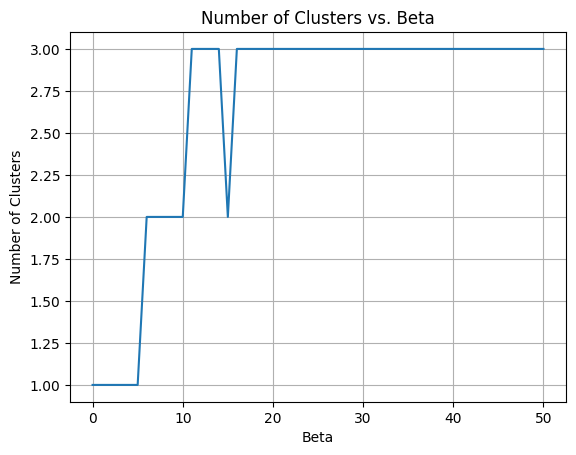

In [17]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-3)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [21]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=10, max_iter=5000, threshold=1e-4)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000


In [22]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [23]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'CHOICE']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_TRAIN_1', 'P_SM_2', 'P_CAR_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 2

 cluster
2    8577
0    2133
Name: count, dtype: int64

 CHOICE     1     2     3
cluster                 
0        695  1409    29
2        728  4804  3045

 max_proba   1     2     3
cluster                  
0          60  2073     0
2           0  6831  1746

 simulated_choice    1     2     3
cluster                          
0                 638  1482    13
2                 795  4740  3042
